In [ ]:
#######################################
###!@0 START INIT ENVIRONMENT
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
#######################################
###!@1 START OF PYSPARK INIT
# Provides findspark.init() to make pyspark importable as a regular library.
# Resource : https://pypi.org/project/findspark/
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT
###!@0 END INIT ENVIRONMENT

Mounted at /content/drive


In [ ]:
#All the necessary import statements
from pyspark.sql.functions import col, lower
import matplotlib.pyplot as plt
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import functions as f
import pandas as pd
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

In [ ]:
years = ["2017_2018", "2018_2019", "2019_2020"]
SouthStates = ["AndhraPradesh", "Karnataka", "Kerala", "TamilNadu", "Telangana"]
basePath = "/content/drive/Shareddrives/DataEngineeringProject/SouthDistricts/"
"""
  Method to read the data for a particular state on particular time period (current default : 2019_2020)
  Drops all the unnecessary columns and replaces nulls with 0 and returns the data
"""
def readAllDataForState(state, year="2019_2020"):
  path = basePath + year + "/" + state + "/*.csv"
  data = spark.read.option("header",True).option("inferSchema",True).csv(path)
  colsNotRequired = ("Building", "Boundary_Wall", "Single_Class_Room",\
                     "Separate_Room_for_Headmaster", "Land_Available", "Electricity",\
                      "Furniture", "Librarian", "Boy_Toilet", "Girl_Toilet", "Drinking_Water")
  data.drop(*colsNotRequired)
  data.na.fill(0)
  return data

In [ ]:
#Load Performance Data
path = "/content/drive/Shareddrives/DataEngineeringProject/SouthDistricts/KarnatakaPerformance_17_18_19.csv"
data = spark.read.option("header",True).option("inferSchema",True).csv(path)

In [ ]:
data17 = data.withColumn('Districts1', lower(col("Districts1"))).select("Districts1", "2017").withColumnRenamed("Districts1", "District_Name").sort("District_Name")
data18 = data.withColumn('Districts2', lower(col("Districts2"))).select("Districts2", "2018").withColumnRenamed("Districts2", "District_Name").sort("District_Name").\
withColumn("District_Name", regexp_replace('District_Name', 'bagalkot', 'bagalkote'))
data19 = data.withColumn('Districts3', lower(col("Districts3"))).select("Districts3", "2019").withColumnRenamed("Districts3", "District_Name").sort("District_Name")

In [ ]:
allYearsData = data17.join(data18, ["District_Name"]).join(data19, ["District_Name"])
allYearsData = allYearsData.withColumn("2018", allYearsData["2018"].cast(DoubleType()))

In [ ]:
allYearsData = allYearsData.sort("District_Name")
allYearsData = allYearsData.sort(col("2017").desc(), col("2018").desc(), col("2019").desc())
allYearsData.show()
renameList = [("bagalkote", "bagalkot"), ("chikodi", "belagavi chikkodi"), ("bengaluru north", "bengaluru u north"),
              ("bengaluru south","bengaluru u south"), ("chamarajanagar","chamarajanagara"), ("chikkaballapur","chikkaballapura"),
              ("chikkamagaluru","chikkamangaluru"), ("kalaburagi","kalburgi"), ("madhugiri","tumakuru madhugiri"),
              ("ramnagara","ramanagara"), ("sirsi","uttara kannada sirsi"), ("yadgir","yadagiri")]

for item in renameList:
  allYearsData = allYearsData.withColumn("District_Name", regexp_replace('District_Name', item[0], item[1]))
#allYearsData.show(40)

+---------------+--------+-----+-----+
|  District_Name|    2017| 2018| 2019|
+---------------+--------+-----+-----+
|          udupi|84.22823|88.18|87.97|
|      mangaluru|82.39469|85.56|86.73|
|        chikodi|80.47415|87.01|84.09|
|          sirsi|80.08518|78.06|84.67|
| uttara kannada|79.82384|88.12|88.12|
|          kolar|  78.506|83.34|86.71|
|        dharwad|77.29343|82.21|75.05|
|         kodagu| 77.0866|80.68|78.81|
|bengaluru rural|77.02682|82.17|88.34|
|         koppal|76.05432|80.43|80.45|
| chamarajanagar|75.66069|74.47|80.58|
|          gadag|75.62136|67.52|74.05|
|     davanagere|75.32614|81.56|85.94|
|     shivamogga|75.06531|78.75|79.13|
|         yadgir|74.83759| null|53.95|
|        ballari|74.65398|82.73|77.98|
| chikkamagaluru|74.40127|72.47|82.76|
|    chitradurga| 72.6382|80.85|87.46|
|     vijayapura|72.22959|83.23|77.36|
|         mysuru|72.03157| 82.9|80.32|
+---------------+--------+-----+-----+
only showing top 20 rows

+--------------------+--------+-----+-

In [ ]:
data = readAllDataForState("Karnataka")

In [ ]:
import pyspark.sql.functions as psf

from pyspark.sql.functions import col
from pyspark.sql.types import StructType

# get all states to a single dataframe with facility data
def get_facilities(states = SouthStates, data = None):

  #columns = ["State_Name", "District_Name", "Location", "School_Management_Name", "Total_Number_of_Schools", "Functional_Electricity", "Solar_Panel", "Playground", "Library_or_Reading_Corner_or_Book_Bank", "Newspaper", "Kitchen_Garden", "Functional_Boy_Toilet", "Functional_Girl_Toilet", "Functional_Toilet_Facility", "Functional_Toilet_and_Urinal", "Functional_Drinking_Water", "Water_Purifier", "Rain_Water_Harvesting", "Handwash", "Incinerator", "Water_Tested", "WASH_Facility_Drinking_Water_Toilet_and_Handwash", "Ramps", "Medical_Checkup", "Complete_Medical_Checkup", "Internet", "Computer_Available"]
  columns = ["State_Name", "District_Name", "Total_Number_of_Schools", "Functional_Electricity", "Playground", "Library_or_Reading_Corner_or_Book_Bank", "Newspaper", "Functional_Boy_Toilet", "Functional_Girl_Toilet", "Functional_Toilet_Facility", "Functional_Urinal_Boy", "Functional_Urinal_Girl", "Functional_Urinal" , "Functional_Toilet_and_Urinal", "Functional_Drinking_Water", "Water_Purifier", "Handwash", "Ramps", "Internet", "Computer_Available"]

  #emptyDFInit = spark.sparkContext.emptyRDD().toDF(StructType([]))
  all_facilities = data

  #print(SouthStates)

  if all_facilities == None: # retrieve dara
    # get data for all states
    for state in states:
      currStateData = readAllDataForState(state).select([col for col in columns])
      
      if all_facilities == None:
        all_facilities = currStateData
      else:
        all_facilities = currStateData.union(all_facilities)
  else: # probably synthetic
    all_facilities = data.select([col for col in columns])

  #all_facilities.show(5)

  return all_facilities

def essentials_schoolper_state(states = SouthStates, data = None):

  columns = ['State_Name', 'District_Name', 'Total_Number_of_Schools', 'Functional_Drinking_Water', 'Functional_Boy_Toilet', 'Functional_Girl_Toilet', \
             'Handwash', 'Functional_Electricity', 'Newspaper', 'Library_or_Reading_Corner_or_Book_Bank', 'Playground', 'Internet', 'Computer_Available', 'Ramps']
  answer = {}
  
  # get facility list of all states
  essential_df = get_facilities(states, data).select([col for col in columns])
  #print(essential_df.count())

  essential_df1 = essential_df.groupBy("State_Name", "District_Name").agg(psf.sum('Total_Number_of_Schools').alias('Total_Number_of_Schools'), \
                                                         psf.sum('Functional_Drinking_Water').alias('Functional_Drinking_Water'), \
                                                         psf.sum('Functional_Boy_Toilet').alias('Functional_Boy_Toilet'), \
                                                         psf.sum('Functional_Girl_Toilet').alias('Functional_Girl_Toilet'), \
                                                         psf.sum('Handwash').alias('Handwash'), \
                                                         psf.sum('Functional_Electricity').alias('Functional_Electricity'), \
                                                         psf.sum('Newspaper').alias('Functional_Newspaper'), \
                                                         psf.sum('Library_or_Reading_Corner_or_Book_Bank').alias('Library_or_Reading_Corner_or_Book_Bank'), \
                                                         psf.sum('Playground').alias('Playground'),\
                                                         psf.sum('Ramps').alias('Ramps'),\
                                                         psf.sum('Internet').alias('Internet'), \
                                                         psf.sum('Computer_Available').alias('Computer_Available'))
  
  #essential_df1.show()

  fields = essential_df1.schema.fields

  for col in fields:
    if str(col.dataType) is not "StringType":
      if col.name == 'Total_Number_of_Schools':
        continue
      
      essential_df1 = essential_df1.withColumn(col.name, (100 * \
                                                     (1 - ((essential_df1['Total_Number_of_Schools'] - essential_df1[col.name]) / essential_df1['Total_Number_of_Schools']))).cast(IntegerType()))


  essential_df1 = essential_df1.drop('Total_Number_of_Schools')
  #essential_df1.show()

  answer['names'] = essential_df1.columns
  answer['values'] = [list(row) for row in essential_df1.collect()]

  return essential_df1, answer

In [ ]:
features = ['Functional_Drinking_Water', 'Functional_Boy_Toilet', 'Functional_Girl_Toilet','Handwash',
            'Functional_Electricity', 'Functional_Newspaper', 'Library_or_Reading_Corner_or_Book_Bank', 'Playground',
            'Internet', 'Computer_Available', 'Ramps']

yearWiseData = {}
for year in years:
  data = readAllDataForState("Karnataka", year)
  ans = essentials_schoolper_state(["Karnataka"], data)
  all_facilities_Ka = ans[0]
  all_facilities_Ka = all_facilities_Ka.drop("State_Name")
  all_facilities_Ka = all_facilities_Ka.withColumn('District_Name', lower(col("District_Name")))
  yearWiseData[year] = all_facilities_Ka.join(allYearsData, ["District_Name"])

In [ ]:
#yearWiseData["2018_2019"].show()

In [ ]:
maxCorrelationFeature = ""
minCorrelationFeature = ""
max = -2
min = 2
#Check  Correlation with facilities
for year in years:
  print(year)
  for feature in features:
    corrVal = yearWiseData[year].stat.corr(feature, year.split("_")[0])#-1, 0, 1
    if corrVal > max:
      max = corrVal
      maxCorrelationFeature = feature
    if corrVal < min:
      min = corrVal
      minCorrelationFeature = feature
    print(feature + " : Correlation --> " + str(corrVal))

2017_2018
Functional_Drinking_Water : Correlation --> nan
Functional_Boy_Toilet : Correlation --> -0.07526264790819245
Functional_Girl_Toilet : Correlation --> -0.007912082350040353
Handwash : Correlation --> 0.3586729039355984
Functional_Electricity : Correlation --> 0.11431995255830453
Functional_Newspaper : Correlation --> 0.4034903233191242
Library_or_Reading_Corner_or_Book_Bank : Correlation --> 0.32728410746420206
Playground : Correlation --> 0.24731278382843433
Internet : Correlation --> 0.09012744870944334
Computer_Available : Correlation --> 0.08011701533090256
Ramps : Correlation --> 0.026760046040385958
2018_2019
Functional_Drinking_Water : Correlation --> 0.257417476366921
Functional_Boy_Toilet : Correlation --> 0.5669198547314678
Functional_Girl_Toilet : Correlation --> 0.4967926287102875
Handwash : Correlation --> 0.21938414587033078
Functional_Electricity : Correlation --> 0.3847382688017578
Functional_Newspaper : Correlation --> 0.03133506858469538
Library_or_Reading_Co

In [ ]:
#print("maxCorrelationFeature : " + maxCorrelationFeature + " -> " + str(max))
#print("minCorrelationFeature : " + minCorrelationFeature + " -> " + str(min))
reducedData = yearWiseData["2019_2020"].select("Library_or_Reading_Corner_or_Book_Bank", "2019")
reducedData = reducedData.toPandas()
x = reducedData["Library_or_Reading_Corner_or_Book_Bank"]
y = reducedData["2019"]

In [ ]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def showCorrelation(x, y, xlab="", ylab=""):
  plt.figure()
  # adds the title
  plt.title('Correlation')
    
  # plot the data
  plt.scatter(x, y)
    
  # fits the best fitting line to the data
  plt.plot(np.unique(x), 
          np.poly1d(np.polyfit(x, y, 1))
          (np.unique(x)), color='red')
    
  # Labelling axes
  plt.xlabel(xlab)
  plt.ylabel(ylab)

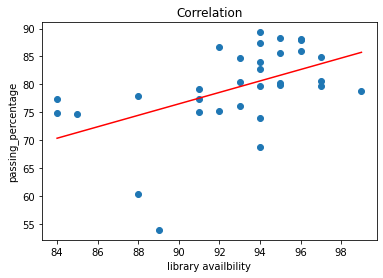

In [ ]:
showCorrelation(x,y, "library availbility", "passing_percentage")

In [ ]:
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from functools import reduce  
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt
from pyspark.sql.functions import regexp_replace

#Below link provides study on hygiene in institutions
#https://www.open.edu/openlearncreate/mod/oucontent/view.php?id=191&printable=1#:~:text=The%20basic%20hygienic%20requirements%20of,as%20noise%2C%20accident%20and%20pollution.

# explicit functions
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

def buildHygieneScoreGetTop10(states, data):
  global index
  answer = {}
  
  for state in states:
    stateData = data[state]
    stateData = stateData.select("State_Name", "District_Name", "Total_Number_of_Schools", "Functional_Toilet_Facility", "Functional_Urinal", "Functional_Drinking_Water", "Water_Purifier", "Water_Tested", "Handwash")
    stateData = stateData.withColumn("HygieneScoreAvg", F.expr("(100 * ((Functional_Drinking_Water * 0.25) +\
                                                                  (Water_Purifier * 0.25) +\
                                                                  (Functional_Toilet_Facility * 0.25) +\
                                                                  (Handwash * 0.15) +\
                                                                  (Functional_Urinal * 0.05) +\
                                                                  (Water_Tested * 0.05)) / Total_Number_of_Schools)"))
    
    stateData = stateData.groupBy("State_Name", "District_Name").avg("HygieneScoreAvg").withColumnRenamed("avg(HygieneScoreAvg)", "HygieneScore")
    answer[state] = stateData
  return answer


In [ ]:
yearWiseData = {}
data = {}
for year in years:
  data["Karnataka"] = readAllDataForState("Karnataka", year)
  all_districts_HygieneScore = buildHygieneScoreGetTop10(["Karnataka"], data)
  all_districts_HygieneScore = all_districts_HygieneScore["Karnataka"]
  all_districts_HygieneScore = all_districts_HygieneScore.drop("State_Name")
  all_districts_HygieneScore = all_districts_HygieneScore.withColumn('District_Name', lower(col("District_Name")))
  yearWiseData[year] = all_districts_HygieneScore.join(allYearsData, ["District_Name"])

In [ ]:
yearWiseData[year].show()

+--------------------+--------------------+--------+-----+-----+
|       District_Name|        HygieneScore|    2017| 2018| 2019|
+--------------------+--------------------+--------+-----+-----+
|               udupi|94.93396851464970000|84.22823|88.18|87.97|
|      uttara kannada|94.18590905519520000|79.82384|88.12|88.12|
|   belagavi chikkodi|82.86531186721560000|80.47415|87.01|84.09|
|  tumakuru madhugiri|87.01357037516350000|71.84346|85.55|84.81|
|            belagavi|86.26748503249790000|71.20096|84.77|77.43|
|              hassan|87.94787912798510000|69.57974|84.68|89.33|
|               kolar|86.40443520121490000|  78.506|83.34|86.71|
|          vijayapura|75.87140290995780000|72.22959|83.23|77.36|
|            tumakuru|88.42943388688170000|68.15447|82.97|79.92|
|              mysuru|86.41334694604790000|72.03157| 82.9|80.32|
|             ballari|85.44949750289910000|74.65398|82.73|77.98|
|             dharwad|84.33184196033750000|77.29343|82.21|75.05|
|     bengaluru rural|88.

In [ ]:
for year in years:
  print(year)
  corrVal = yearWiseData[year].stat.corr("HygieneScore", year.split("_")[0])
  print(corrVal)

2017_2018
0.3689486295083804
2018_2019
0.55193477879905
2019_2020
0.3553997957870792


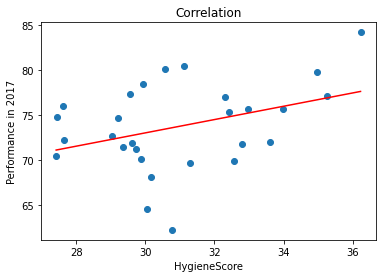

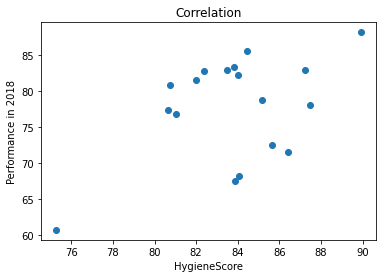

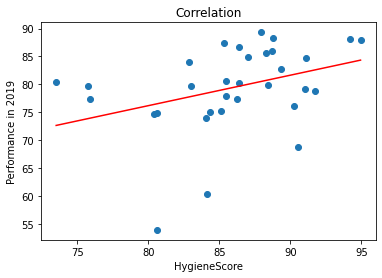

In [ ]:
for year in years:
  ylab = year.split("_")[0]
  reducedData = yearWiseData[year].select("HygieneScore", ylab)
  reducedData = reducedData.withColumn("HygieneScore", reducedData["HygieneScore"].cast(DoubleType()))
  reducedData = reducedData.toPandas()
  x = reducedData["HygieneScore"]
  y = reducedData[ylab]

  showCorrelation(x,y, "HygieneScore", "Performance in " + ylab)